# Machine Learning Engineer Nanodegree
## Capstone Project
Andres Mechali

June 6th, 2017

## I. Definition

### Project Overview

This project is taken from the Kaggle platform, and is currently available under the name _Quora Question Pairs_ in this link: https://www.kaggle.com/c/quora-question-pairs. Quora is a platform where anyone can make a question, and other users give answers. According to Quora, they receive over 100 million visits every month, so it's very common that the question someone asks has already been answered by others. In order to make it easier for someone to find an answer, they use a Random Forest model to identify duplicate questions.

This project is about finding a model that can determine wether a pair of questions has the same meaning or not. The input data is a dataset of about 400,000 pair of questions with a human provided label stating if they have the same meaning. As for testing, Kaggle provides a set of unlabeled pairs, which are then compared to their own human labeled results.

### Problem Statement

The problem consists on analyzing different pairs of questions made by Quora users, and determining if they are basically asking the same thing. In this way, when a user asks something that has already been asked, he or she can be refered to a prior question which already has answers.

For solving this problem, I will start analyzing the basic aspects from the training set, and obtaining a benchmark predictor. Then, I will preprocess the data and create new features which may be helpful. After this, I will test some models and determine which is the best for using in this case. I will tune the parameters using GridSearchCV, and apply the chosen model to the testing set. Finally, I will upload the results to Kaggle and compare the log-loss obtained with the one from the benchmark. This log-loss should be smaller, which means that the model is better than a naive predictor, and gives some extra information about the data.

### Metrics

The metrics that I will use for measuring the performance of the models will be the log-loss. This is a very commonly used metrics in models where the output is the probability of a binary outcome, which is the case of this project. This metrics penalize wrong classifications depending on how confident the model was about them. Specifically, a prediction with a greater level of confidence is more penalized when wrong.

Another reason for choosing log-loss as a metrics is because it is the one used in the Kaggle platform to evaluate the predictions. So, by using this while training, I can compare the results with other Kaggle users.

## II. Analysis

### Data Exploration

First of all, I need to import the basic libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

Now I will import the training set, and display the first 5 lines.

In [2]:
data_train = pd.read_csv('data/train.csv')
data_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In this dataset we can find the following information:
* qid1: Unique ID of question 1
* qid2: Unique ID of question 2
* question1: Content of question 1
* question2: Content of question 2
* is_duplicate: A label stating if both questions are the same (1) or not (0)

Next, I will display some basic statistics about the dataset.

In [4]:
print("Number of rows: %d" %len(data_train))
dup = data_train[data_train.is_duplicate == 1]
n_dup = data_train[data_train.is_duplicate == 0]
print("Duplicate pair of questions: %d" %len(dup))
print("Not duplicate pair of questions: %d" %len(data_train[data_train.is_duplicate == 0]))

qids = data_train.qid1.tolist() + data_train.qid2.tolist()
print("Unique questions: %d" %len(set(qids)))

Number of rows: 404290
Duplicate pair of questions: 149263
Not duplicate pair of questions: 255027
Unique questions: 537933


### Exploratory Visualization

Now I will do a brief analysis of the questions in the training set. I will use the Natural Language Tool Kit (nltk) for this, and I will display an histogram to see the frequency of the lengths of the questions.

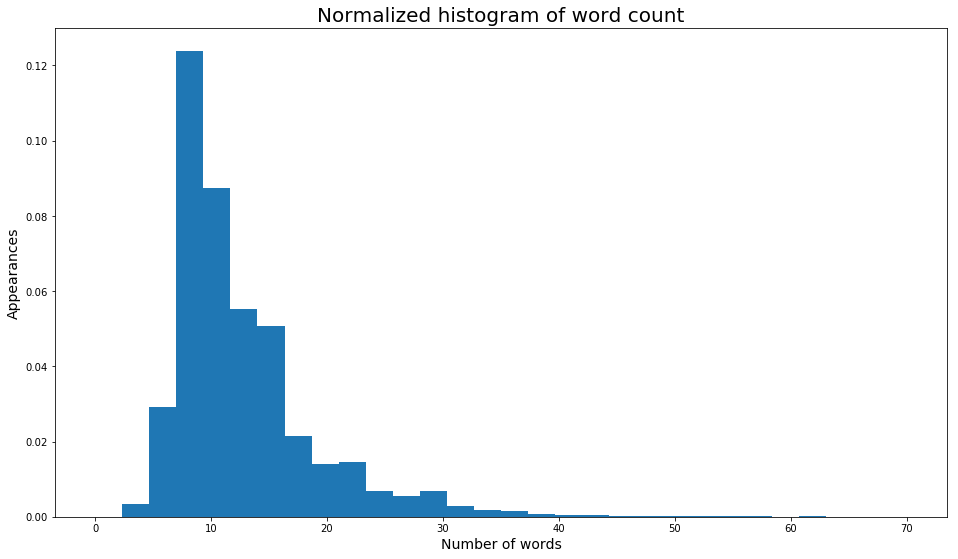

In [3]:
import nltk

q_tok = []
q_tok += [nltk.tokenize.word_tokenize(i) for i in data_train.question1.apply(lambda x: str(x).decode('utf-8'))]
q_tok += [nltk.tokenize.word_tokenize(i) for i in data_train.question2.apply(lambda x: str(x).decode('utf-8'))]

word_count = [len(i) for i in q_tok]

plt.figure(figsize=(16,9))
plt.hist(word_count, bins=30, range=[0,70], normed=True)
plt.title("Normalized histogram of word count", fontsize=20)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Appearances", fontsize=14)
plt.show()

As we will see here, most of the questions are composed from about 8 to 12 words. There are some of them which can have even more than 50 words. I will not exclude these outliers, because when comparing lengths I will use the absolute value, and not a normalized one. Hence, outliers should not affect my outcome. 

### Algorithms and Techniques

For this project I will evaluate 3 algorithms: AdaBoost, Random Forest and XGBoost. The reason for this is that they are all ensemble methods, which work well for problems where the features are weak learners. In this problem all the features will be so, because there doesn't seem to be one that is highly correlated with the meaning of the question.

I will try the 3 models and determine which has the minimum log-loss. After that, I will tune this model to find the best possible parameters for this problem.

### Benchmark: Naive predictor
As a Benchmark for testing the effectiveness of this model, I will use a predictor that evaluates if two questions are equal just based on the probability of this happening. I will assign this same probability to every pair of questions. I will upload this result to the Kaggle platform an evaluate the log-loss obtained. This will be my benchmark to see if I can obtain a better model for this.

In [ ]:
prob = data_train.is_duplicate.mean()

In [62]:
data_test = pd.read_csv("data/test.csv")

In [7]:
submission = pd.DataFrame(data_test.test_id)

In [8]:
test_is_duplicate = []

for i in range(len(submission.test_id)):
    test_is_duplicate.append(prob)

In [9]:
submission['is_duplicate'] = test_is_duplicate
submission.head()

,test_id,is_duplicate
0,0,0.369198
1,1,0.369198
2,2,0.369198
3,3,0.369198
4,4,0.369198


In [10]:
submission.to_csv('sub/naive_predictor.csv', index=False)

The log-loss obtained was **0.55411**. This will be used as a benchmark, and any model with a lower value will be considered better.

In [11]:
del submission

## III. Methodology

### Data Preprocessing

I will now pre process the raw data, for which I will need a series of steps stated below:

* Removing stop words: The first step will be to remove all words that are considered not to give valuable information about the content of the question. Examples of this will be _you_, _have_, _the_, _to_, etc., and punctuation.
* Applying stemming: In order to consider the same word _car_ and _cars_, I will apply a stemming algorithm that keeps the root of each word.
* Tokenize: I will split questions into list of words, so that I can loop and compare them easily.
* Tf-Idf: With this I will consider the importance of a word related to it's frequency, instead of considering them equal. The fact that 2 question share a word that appears often will be less important than if they share a rare word.
* DiffLib: This is a Python library that will help me finding differences between 2 strings. Specifically, I will be using the SequenceMatcher method.

By doing these steps, I will get a new set of features, which will be composed of:
* shared_weights: a measure of how many words both questions share, weighted by the tf-idf value of each word.
* shared_count_scaled: it will represent the normalized amount of words that they have in common.
* len_dif: the difference between the lengths of the questions.
* z_match_ratio: the value obtained from the SequenceMatcher method.

I will also check if these features seem relevant to classify between equal and unequal questions. For this, I will use histograms.


### Implementation

First, I will define all the functions that I will use for preprocessing.

###### Removing stop words and applying stemming.

In [4]:
# Import libraries
from nltk.stem.snowball import SnowballStemmer
import re
from nltk.corpus import stopwords

# Define stemmer method and stop words
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}']) # Adds punctuation to stopwords


def cleanQuestions(q_list):
    clean_questions = []

    for i in range(len(q_list)):
        q1 = ''
        for j in re.findall(r"[\w']+", str(q_list[i])):
            if j not in stop_words:
                q1 += stemmer.stem(j)
                q1 += " "
        q = ''
        for j in q1.split(): # Because the first words where not taken before
            if j not in stop_words:
                q += j
                q += " "
        clean_questions.append(q.strip()) # To remove the last blank space
        
    return clean_questions

###### Tf-Idf

Now I will apply a TF-IDF model in order to get the relative importance of each word. In this way, words which appear more often will be less important than words that appear less.

First, I need to identify the unique questions, because some of them are repeated in the dataset and otherwise would generate a different result.

In [5]:
def uniqueQuestions(questions1_clean, questions2_clean):
    questions = []

    for i in tqdm(range(len(questions1_clean))):
        questions.append(str(questions1_clean[i]))
        questions.append(str(questions2_clean[i]))
    
    questions = set(questions)

    print("There are %d unique questions in the dataset." %len(questions))
    
    return questions

In [6]:
def tfIdfVectorizer(questions):
    # Import the library
    from sklearn.feature_extraction.text import TfidfVectorizer
    # Obtain the Tf-Idf value of each word, using the TfidfVectorizer function from sklearn
    vectorizer = TfidfVectorizer(max_df=0.5)
    tfidf = vectorizer.fit_transform(questions)
    idf = vectorizer.idf_
    # Create and return a dictionary with every word as a key, and its respective weight as a value
    return dict(zip(vectorizer.get_feature_names(), idf))

###### Tokenize

In [7]:
def tokenizeQuestions(q):
    return [nltk.tokenize.word_tokenize(i) for i in q]

###### Getting the weighted percentage of shared words

First, I need a list of the shared words, and a list of all the words for each pair

In [8]:
def sharedWords(q1, q2):
    shared_words = []
    total_words = []

    for i in tqdm(range(len(q1))):
        shared = []
        total = []
        for w in q1[i]:
            total.append(w)
            if w in q2[i]:
                shared.append(w)
        for w in q2[i]:
            total.append(w)
            if w in q1[i]:
                shared.append(w)
        shared_words.append(shared)
        total_words.append(total)
    return shared_words, total_words

I will now create 2 new lists with the shared and total weights, using the idf dictionary created before.

In [9]:
def sharedWeights(shared_words, total_words):
    shared_weights = []
    total_weights = []
    not_in_dict = []
    for i in tqdm(range(len(shared_words))):
        shared = []
        total = []
        for w in shared_words[i]:
            try:
                shared.append(idf_dict[w])
            except:
                not_in_dict.append(w)
                shared.append(0)
        for w in total_words[i]:
            try:
                total.append(idf_dict[w])
            except:
                not_in_dict.append(w)
                shared.append(0)
        shared_weights.append(shared)
        total_weights.append(total)
    return shared_weights, total_weights

Finally, I need a list that has the sum of all the shared weights divided by the sum of all the weights for each pair of questions.

In [10]:
def getWeights(shared_weights, total_weights):
    weights = []
    for i in range(len(shared_weights)):
        shared = 0
        total = 0
        for j in range(len(shared_weights[i])):
            shared += shared_weights[i][j]
        for j in range(len(total_weights[i])):
            total += total_weights[i][j]
        if total == 0:
            weights.append(0)
        else:
            weights.append(shared / total)
    return weights

###### I will now apply these transformations to the training dataset.

In [11]:
questions1 = data_train.question1.tolist()
questions2 = data_train.question2.tolist()

questions1_clean = cleanQuestions(questions1)
questions2_clean = cleanQuestions(questions2)

questions = uniqueQuestions(questions1_clean, questions2_clean)

100%|██████████████████████████████████████████████████████████████████████| 404290/404290 [00:00<00:00, 713033.62it/s]


There are 509543 unique questions in the dataset.


In [12]:
idf_dict = tfIdfVectorizer(questions)

In [13]:
unique_tokens = [nltk.tokenize.word_tokenize(str(i)) for i in questions]

In [14]:
question1_token = tokenizeQuestions(questions1_clean)
print 'Questions 1 tokenized.'
question2_token = tokenizeQuestions(questions2_clean)
print 'Questions 2 tokenized.'

shared_words, total_words = sharedWords(question1_token, question2_token)

Questions 1 tokenized.
Questions 2 tokenized.


100%|███████████████████████████████████████████████████████████████████████| 404290/404290 [00:05<00:00, 78018.14it/s]


In [15]:
shared_weights, total_weights = sharedWeights(shared_words, total_words)

100%|███████████████████████████████████████████████████████████████████████| 404290/404290 [00:05<00:00, 75021.34it/s]


In [16]:
weights = getWeights(shared_weights, total_weights)

I will start a new DataFrame and fill it with the features I create.

In [17]:
X = pd.DataFrame(weights, columns=['shared_weights'])
X.head()

,shared_weights
0,0.950408
1,0.652899
2,0.517698
3,0.000000
4,0.237645


In order to be able to test the algorithms, I will now generate a new DataFrame with the label for each pair of questions. This label will have value 0 if they don't mean the same, and 1 if they do.

In [18]:
y = pd.DataFrame(data_train.is_duplicate, columns=['is_duplicate'])

For each new feature that I create, I will plot the distribution of the duplicate and non duplicate questions, in order to see if this feature seems to be useful for predicting. I will start defining a function that will allow me to do this easier.

In [29]:
def plotDistribution(feature, desc):
    plt.figure(figsize=(15, 5))
    plt.hist(X[y['is_duplicate'] == 0][feature].tolist(), bins=20, normed=True, label='Not Duplicate')
    plt.hist(X[y['is_duplicate'] == 1][feature].tolist(), bins=20, normed=True, alpha=0.7, label='Duplicate')
    plt.legend()
    plt.title('Label distribution over ' + desc, fontsize=15)
    plt.xlabel(desc, fontsize=15)
    plt.ylabel('frequency', fontsize=15)
    plt.show()

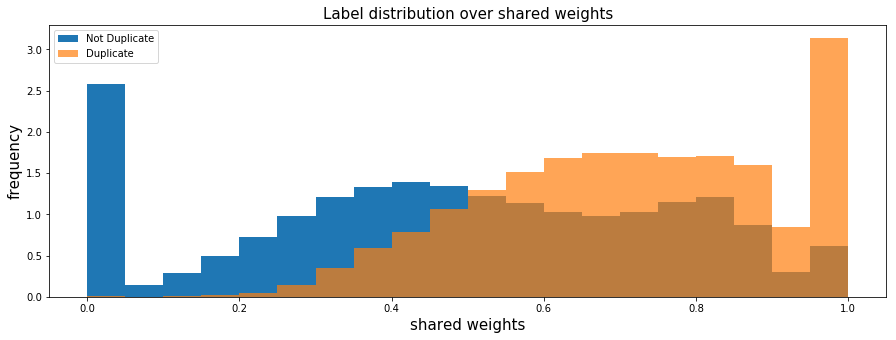

In [30]:
plotDistribution('shared_weights', 'shared weights')

This feature, **shared_weights**, looks to give some information about the equalness of a pair of questions.

The next feature I will generate will be the number of shared words in both questions.

In [19]:
shared_count = [len(x) for x in shared_words]

In order to see the distribution of this feature, I will plot an histogram. I will define a function that will allow me to do this easier for future features.

In [32]:
def plotHistogram(feature, desc):
    plt.figure(figsize=(15, 5))
    plt.hist(feature, bins=40)
    plt.title('Distribution of ' + desc, fontsize=15)
    plt.xlabel(desc, fontsize=15)
    plt.ylabel('frequency', fontsize=15)
    plt.show()

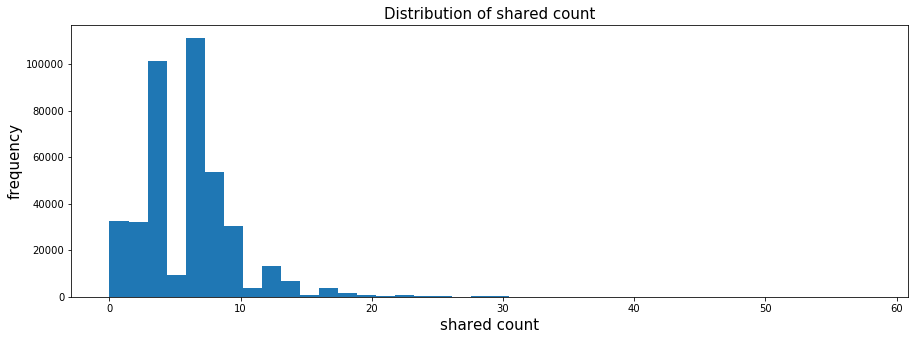

In [33]:
plotHistogram(shared_count, 'shared count')

In order to make it more relevant, I will use the MinMaxScaler function of sklearn, for scaling this feature before using it. As we can see in the prior histogram, most of the cases share 10 words or less, so including the ones with higher values will make this scaling to lose power. I will therefor consider all the cases with more than 10 shared words as if they had just 10.

In [20]:
from sklearn.preprocessing import MinMaxScaler

shared_count_cut = [x if x < 10 else 10 for x in shared_count]

shared_count_scaled = MinMaxScaler().fit_transform(np.array(shared_count_cut, dtype='float64').reshape(-1, 1))

X['shared_count_scaled'] = shared_count_scaled.reshape(-1, 1)

del shared_count, shared_count_cut, shared_count_scaled

X.head()

,shared_weights,shared_count_scaled
0,0.950408,1.0
1,0.652899,0.8
2,0.517698,0.6
3,0.000000,0.0
4,0.237645,0.4


To see how useful this feature is, I will use the function created before and analyze the plot.

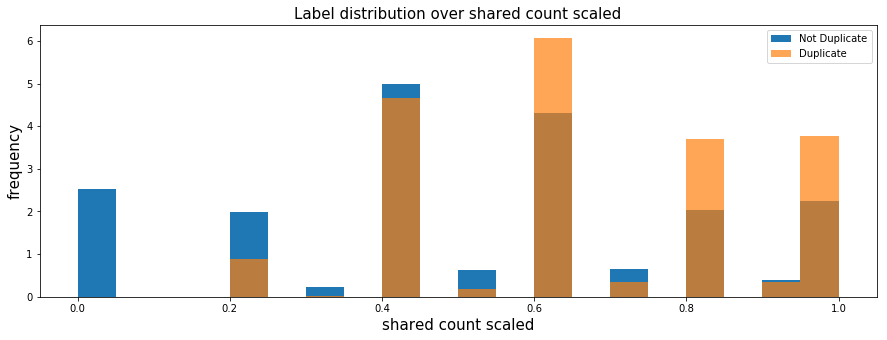

In [35]:
plotDistribution('shared_count_scaled', 'shared count scaled')

I can see that pairs with a higher value tend to be duplicated in more cases than the ones with lower values.

The next feature I will add is the difference in the length of the question. Again, I will scale it to get a value between 0 and 1.

In [21]:
question1_len = [len(x) for x in question1_token]
question2_len = [len(x) for x in question2_token]

len_dif = []

for i in range(len(question1_len)):
    len_dif.append(abs(question1_len[i] - question2_len[i]))

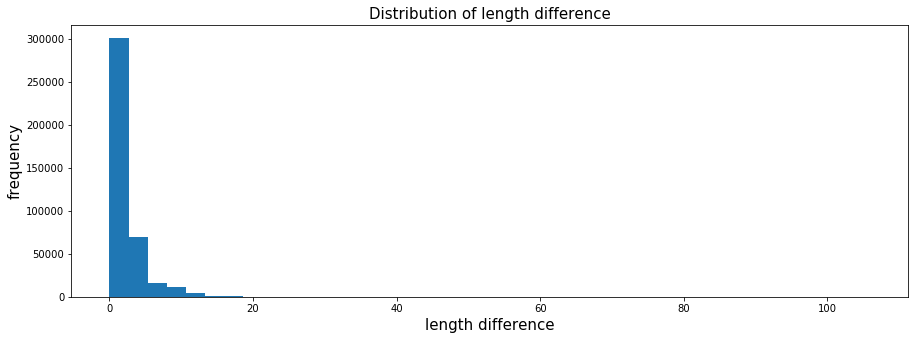

In [37]:
plotHistogram(len_dif, 'length difference')

I can see from this plot that most of the values are lower than 5, so again I will convert higher values to 5, and then rescale it with the MinMaxScaler method.

In [22]:
len_dif_cut = [5 if i > 5 else i for i in len_dif]
len_dif_cut = np.array(len_dif_cut).reshape(-1, 1)

len_dif_scaled = MinMaxScaler().fit_transform(len_dif_cut)

X['len_dif'] = len_dif_scaled

del len_dif, len_dif_cut

X.head()

C:\Users\andres\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


,shared_weights,shared_count_scaled,len_dif
0,0.950408,1.0,0.2
1,0.652899,0.8,1.0
2,0.517698,0.6,0.2
3,0.000000,0.0,1.0
4,0.237645,0.4,1.0


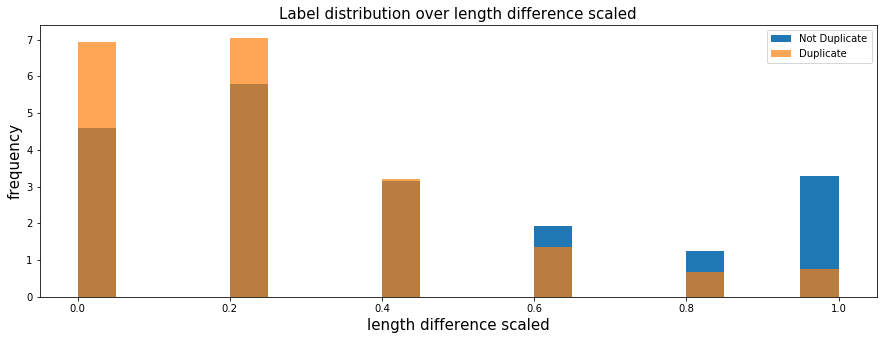

In [39]:
plotDistribution('len_dif', 'length difference scaled')

Again, this feature seems to be useful for predicting.

### DiffLib

In [23]:
import difflib

def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()

In [24]:
z_match_ratio = []

for i in tqdm(range(len(data_train))):
    z_match_ratio.append(diff_ratios(data_train.question1[i], data_train.question2[i]))
                         
X['z_match_ratio'] = z_match_ratio

X.head()

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [02:53<00:00, 2331.88it/s]


,shared_weights,shared_count_scaled,len_dif,z_match_ratio
0,0.950408,1.0,0.2,0.926829
1,0.652899,0.8,1.0,0.661871
2,0.517698,0.6,0.2,0.439394
3,0.000000,0.0,1.0,0.086957
4,0.237645,0.4,1.0,0.365217


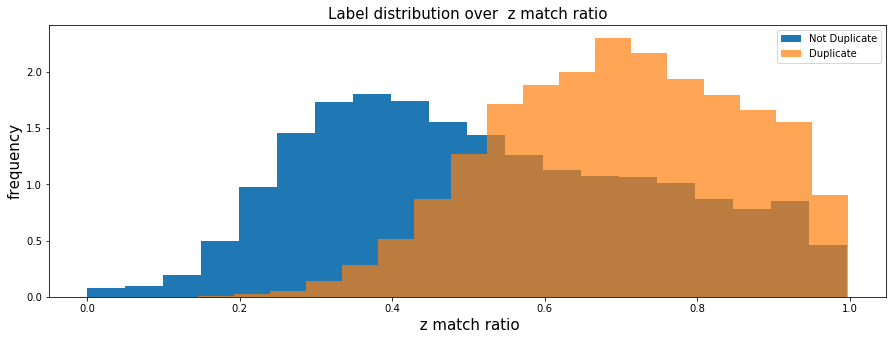

In [42]:
plotDistribution('z_match_ratio', ' z match ratio')

Finally, I will split the features and labels into a training and test set, in order to look for a good model. At the end, when I finally decide which to use, I will use the whole set for training, and I will test using the Kaggle testing set.

In [29]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

###### Model selection

Now that I have both the features that I will try, and the labels for each data point, I will start with the analysis of 3 different models which might obtain a good result: Random forest, AdaBoost and XGBoost.

In [46]:
from sklearn.metrics import log_loss

###### AdaBoost

In [47]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(random_state=50)
clf.fit(x_train, np.ravel(y_train))

pred = clf.predict_proba(x_test)

print 'Log loss: %f' %log_loss(y_test, pred)

Log loss: 0.680521


###### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

clf= RandomForestClassifier(n_estimators=100)

clf.fit(x_train, np.ravel(y_train))

pred = clf.predict_proba(x_test)

print 'Log loss: %f' %log_loss(y_test, pred)

Log loss: 0.642770


###### XGBoost

In [26]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb

In [52]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

bst = xgb.train(params, d_train, 100, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.687572	test-logloss:0.687664
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.641881	test-logloss:0.64272
[20]	train-logloss:0.609619	test-logloss:0.611001
[30]	train-logloss:0.586164	test-logloss:0.587946
[40]	train-logloss:0.568615	test-logloss:0.570723
[50]	train-logloss:0.554917	test-logloss:0.557311
[60]	train-logloss:0.544427	test-logloss:0.547042
[70]	train-logloss:0.53638	test-logloss:0.539185
[80]	train-logloss:0.530119	test-logloss:0.533051
[90]	train-logloss:0.525184	test-logloss:0.528213
[99]	train-logloss:0.521324	test-logloss:0.524459


As we can see, the three models have a similar log-loss, so in order to determine which is potentially better, I should tune each of them to find the best possible parameters. In the next section, I will focus on that.

### Refinement

In order to find which is the best of the three models, I will tune them and see which one gives me the lowest log-loss. For tuning, I will use the GridSearchCV tool from the scikit-learn library.

In [53]:
from sklearn.model_selection import GridSearchCV

I will now define a function that will allow me to use GridSearchCV in a simpler way.

In [54]:
def gridSearch(clf, base=None, params={}, base_params={}):
    start = time.time()
    
    param_grid = dict()
    for i in params.keys():
        param_grid[i] = params[i]
    for i in base_params.keys():
        param_grid['base_estimator__' + i] = base_params[i]
    if base == None:
        pass
    else:
        clf = type(clf)(base_estimator=base, random_state=50)
    gs = GridSearchCV(clf, param_grid, scoring='neg_log_loss')
    gs.fit(x_train, np.ravel(y_train))
    
    end = time.time()
    
    pred = gs.predict_proba(x_test)
    print 'Time taken: %f seconds' %(end - start)
    print 'Log loss: %f' %log_loss(y_test, pred)
    best_params = [i + ': ' + str(gs.best_params_[i]) for i in gs.best_params_.keys()]
    print 'Best parameters:'
    if params != {}:
        print '   Classifier:'
        for i in range(len(params.keys())):
            print '      ' + best_params[i]
    if base_params != {}:
        print '   Base Estimator:'
        for i in range(len(base_params.keys())):
            print '      ' + best_params[i + len(params.keys())][16:]

For every model I will apply GridSearchCV to a series of parameters that I consider they have a bigger effect on log-loss. I tried every single parameter before, and given the results I chose these. In order to make it quicker, I will try them separately. If I put all of them together the search can take a very long time.

###### AdaBoost

In [82]:
gridSearch(AdaBoostClassifier(random_state=50), 
           base=DecisionTreeClassifier(), 
           base_params={'min_samples_split':[10, 30], 
                        'min_samples_leaf':[10, 30]})

Time taken: 6103.126000 seconds
Log loss: 0.542687
Best parameters:
   Base Estimator:
      min_samples_split: 10
      min_samples_leaf: 30


In [83]:
gridSearch(AdaBoostClassifier(random_state=50),
          base=DecisionTreeClassifier(min_samples_split=10,
                                     min_samples_leaf=30),
           params={'n_estimators':[70, 50]},
           base_params={'min_weight_fraction_leaf': [0.0, 0.01]}
          )

Time taken: 4112.519000 seconds
Log loss: 0.541626
Best parameters:
   Classifier:
      n_estimators: 70
   Base Estimator:
      min_weight_fraction_leaf: 0.0


In [84]:
gridSearch(AdaBoostClassifier(n_estimators=70, random_state=50),
          base=DecisionTreeClassifier(min_samples_split=10,
                                     min_samples_leaf=30,
                                     min_weight_fraction_leaf=0.0),
           params={'learning_rate':[0.1, 0.3, 0.5]})

Time taken: 7695.744000 seconds
Log loss: 0.542683
Best parameters:
   Classifier:
      learning_rate: 0.5


The best log-loss that I can get from the AdaBoost algorithm is **0.54**.

###### Random Forest

In [58]:
gridSearch(RandomForestClassifier(random_state=50), 
          params={'n_estimators':[100, 200]})

Time taken: 1420.078000 seconds
Log loss: 0.620234
Best parameters:
   Classifier:
      n_estimators: 200


In [59]:
gridSearch(RandomForestClassifier(n_estimators=200, 
                                  random_state=50), 
          params={'min_samples_leaf': [5, 10]})

Time taken: 978.054000 seconds
Log loss: 0.500243
Best parameters:
   Classifier:
      min_samples_leaf: 10


The best log-loss obtained from RandomForest is **0.50**.

###### XGBoost

In order to use GridSearchCV with XGBoost, I will need to use the sklearn implementation of this algorithm.

In [60]:
xgbclf = xgb.XGBClassifier(seed=50)

gridSearch(xgbclf, 
          params={'max_depth': [2, 3, 4],
                 'reg_alpha': [0.3, 0.5]})

Time taken: 146.339000 seconds
Log loss: 0.501172
Best parameters:
   Classifier:
      reg_alpha: 0.5
      max_depth: 4


In [61]:
xgbclf = xgb.XGBClassifier(max_depth=4, 
                           reg_alpha=0.5,
                           seed=50)

gridSearch(xgbclf, 
          params={'learning_rate': [0.1, 0.3, 0.5],
                 'gamma': [0.0, 0.1]})

Time taken: 203.543000 seconds
Log loss: 0.496270
Best parameters:
   Classifier:
      learning_rate: 0.3
      gamma: 0.0


In [62]:
xgbclf = xgb.XGBClassifier(max_depth=4, 
                           reg_alpha=0.5,
                           learning_rate=0.3,
                           gamma=0.0,
                           seed=50)

gridSearch(xgbclf, 
          params={'reg_lambda': [0.5, 0.7, 1],
                 'min_child_weight': [0.5, 1, 2]})

Time taken: 254.422000 seconds
Log loss: 0.496455
Best parameters:
   Classifier:
      reg_lambda: 1
      min_child_weight: 0.5


The log loss obtained from XGBoost is **0.49**.

I will choose the **XGBoost** algorithm, given that it has the lowest log loss, and it is by far the fastest to train.

###### Rebalancing positive an negative cases

Based on this article from Kaggle and it's comments, I know that the distribution of possitive and negative cases in the test data is not the same as the one in the training data: https://www.kaggle.com/davidthaler/quora-question-pairs/how-many-1-s-are-in-the-public-lb/run/1013730. In the training data we have around 37% of positive cases, while the test data has around 16.5%.
So for having a better score from Kaggle I need to rebalance the data.

In [27]:
pos_train = X[y.is_duplicate == 1]
neg_train = X[y.is_duplicate == 0]

p = 0.165 # target ratio

n = 0

print 'Unbalanced ratio: %f' %(1.0 * len(pos_train) / (len(pos_train) + len(neg_train)))

while 1.0 * len(pos_train) / (len(pos_train) + len(neg_train)) >= p:
    if n < len(neg_train):
        neg_train = neg_train.append(neg_train[n:n+50])
        n += 50
    
print 'Balanced ratio: %f ' %(1.0 * len(pos_train) / (len(pos_train) + len(neg_train)))

X_r = pd.concat([pos_train, neg_train])
y_r = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train



Unbalanced ratio: 0.369198
Balanced ratio: 0.164997 


In [30]:
x_train, x_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.2, random_state=50)

I will try tuning some extra parameters, given the balanced set. 

In [68]:
xgbclf = xgb.XGBClassifier(max_depth=4, 
                           reg_alpha=0.5,
                           learning_rate=0.3,
                           gamma=0.0,
                           seed=50)

gridSearch(xgbclf, 
          params={'reg_lambda': [0.5, 0.7, 1],
                 'min_child_weight': [0.5, 1, 2]})

Time taken: 539.233000 seconds
Log loss: 0.352851
Best parameters:
   Classifier:
      reg_lambda: 1
      min_child_weight: 1


In [77]:
xgbclf = xgb.XGBClassifier(n_estimators=500,
                           reg_alpha=0.5,
                           learning_rate=0.3,
                           gamma=0.0,
                           reg_lambda=1,
                           min_child_weight=1,
                           seed=50)

gridSearch(xgbclf, 
          params={'max_depth': [4, 6]})

Time taken: 765.717000 seconds
Log loss: 0.344847
Best parameters:
   Classifier:
      max_depth: 6


This is the final classifier that I will use for testing in the Kaggle testing set.

In [32]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['n_estimators'] = 500
params['max_depth'] = 4
params['reg_alpha'] = 0.5
params['learning_rate'] = 0.3
params['gamma'] = 0.0
params['reg_lambda'] = 1
params['min_child_weight'] = 1
params['seed'] = 500



d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

bst = xgb.train(params, d_train, 300, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.557866	test-logloss:0.557919
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.364006	test-logloss:0.364704
[20]	train-logloss:0.357473	test-logloss:0.358471
[30]	train-logloss:0.355758	test-logloss:0.356926
[40]	train-logloss:0.353992	test-logloss:0.35549
[50]	train-logloss:0.352719	test-logloss:0.354545
[60]	train-logloss:0.352102	test-logloss:0.354134
[70]	train-logloss:0.351432	test-logloss:0.35369
[80]	train-logloss:0.350748	test-logloss:0.353221
[90]	train-logloss:0.350379	test-logloss:0.353052
[100]	train-logloss:0.349975	test-logloss:0.352831
[110]	train-logloss:0.349715	test-logloss:0.352699
[120]	train-logloss:0.349305	test-logloss:0.352428
[130]	train-logloss:0.348896	test-logloss:0.352204
[140]	train-logloss:0.348585	test-logloss:0.352067
[150]	train-logloss:0.348277	test-logloss:0.351969
[160]	train-logloss:0.347995	test-logloss:0.3518

We can now see how important each feature was, by checking their f-score. We can see that the most important is shared_weights, followed by z_match_ratio.

In [59]:
feature_importance = pd.DataFrame(bst.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance

,feature,importance
1,shared_weights,1928
2,z_match_ratio,1392
0,shared_count_scaled,480
3,len_dif,286


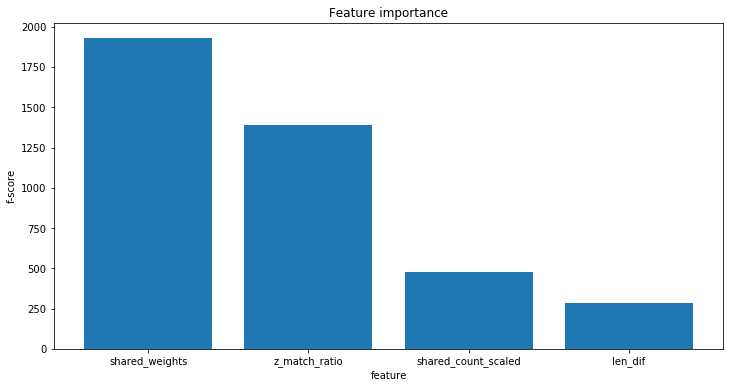

In [80]:
plt.figure(figsize=(12,6))
plt.title('Feature importance')
plt.ylabel('f-score')
plt.xlabel('feature')
plt.bar(range(len(feature_importance.feature)), feature_importance.importance, tick_label=feature_importance.feature)
plt.show()

## IV. Results

### Model Evaluation and Validation
Having already decided the model to use, I applied the same transformations to the provided testing data set, in order to get the new features and be able to make predictions.
This provided a different input to test the model, besides the one obtained from the train_test_split method. This new testing set doesn't have the labels in order to test it by my own, but it is possible to test in on the Kaggle platform. This is good, because this data is not used during the training set, so it provides a very robust indicator.

In [115]:
data_test = pd.read_csv("data/test.csv")

In [118]:
questions1_t = data_test.question1.tolist()
questions2_t = data_test.question2.tolist()

questions1_clean_t = cleanQuestions(questions1_t)
questions2_clean_t = cleanQuestions(questions2_t)

questions_t = uniqueQuestions(questions1_clean_t, questions2_clean_t)

100%|██████████████████████████████████████████████████████████████████████| 800000/800000 [00:01<00:00, 637450.14it/s]


There are 1309083 unique questions in the dataset.


In [119]:
idf_dict_t = tfIdfVectorizer(questions_t)

In [120]:
unique_tokens_t = [nltk.tokenize.word_tokenize(str(i)) for i in questions_t]

question1_token_t = tokenizeQuestions(questions1_clean_t)
print 'Questions 1 tokenized.'
question2_token_t = tokenizeQuestions(questions2_clean_t)
print 'Questions 2 tokenized.'

Questions 1 tokenized.
Questions 2 tokenized.


In [121]:
shared_words_t, total_words_t = sharedWords(question1_token_t, question2_token_t)

shared_weights_t, total_weights_t = sharedWeights(shared_words_t, total_words_t)

weights_t = getWeights(shared_weights_t, total_weights_t)

X_t = pd.DataFrame(weights_t, columns=['shared_weights'])

100%|███████████████████████████████████████████████████████████████████████| 800000/800000 [00:19<00:00, 41876.05it/s]


In [122]:
shared_count_t = [len(x) for x in shared_words_t]

shared_count_cut_t = [x if x < 10 else 10 for x in shared_count_t]

shared_count_scaled_t = MinMaxScaler().fit_transform(np.array(shared_count_cut_t, dtype='float64').reshape(-1, 1))

X_t['shared_count_scaled'] = shared_count_scaled_t.reshape(-1, 1)

del shared_count_t, shared_count_cut_t, shared_count_scaled_t

In [123]:
question1_len_t = [len(x) for x in question1_token_t]
question2_len_t = [len(x) for x in question2_token_t]

len_dif_t = []

for i in range(len(question1_len_t)):
    len_dif_t.append(abs(question1_len_t[i] - question2_len_t[i]))
    
len_dif_cut_t = [5 if i > 5 else i for i in len_dif_t]
len_dif_cut_t = np.array(len_dif_cut_t).reshape(-1, 1)

len_dif_scaled_t = MinMaxScaler().fit_transform(len_dif_cut_t)

X_t['len_dif'] = len_dif_scaled_t

del len_dif_t, len_dif_cut_t

In [124]:
z_match_ratio_t = []

for i in tqdm(range(len(data_test))):
    z_match_ratio_t.append(diff_ratios(data_test.question1[i], data_test.question2[i]))
                         
X_t['z_match_ratio'] = z_match_ratio_t

X_t.head()

100%|████████████████████████████████████████████████████████████████████████| 800000/800000 [05:57<00:00, 2237.73it/s]


,shared_weights,shared_count_scaled,len_dif,z_match_ratio
0,0.462724,0.4,0.6,0.482143
1,0.849017,1.0,0.2,0.872340
2,0.195411,0.2,1.0,0.289157
3,0.676804,0.6,0.4,0.780000
4,0.000000,0.0,0.6,0.345455


In [35]:
dtest = xgb.DMatrix(X_t)
y_t = bst.predict(dtest)

In [43]:
y_pred = pd.DataFrame()
y_pred['test_id'] = range(y_t.shape[0])
y_pred['is_duplicate'] = y_t

In [45]:
y_pred.to_csv('sub/final', index=False)

### Justification

The **final score** obtained in the Kaggle platform is **0.39205**, which is an improvement over the benchmark of **0.55411**. This means that when tested with a totally different input, the results are very similar from the ones obtained before. Still, it is not low enough to be considered an optimal solution to the problem. This value should be improved in order to make significantly good recommendations.

## V. Conclusion

### Reflection

For this project, I started analyzing the basic aspects of the dataset, and getting a naive predictor to use as a benchmark and see if my model would represent an improvement. After this, I preprocessed the training data, and tested that each new feature showed graphically a different distribution between duplicate and non duplicate pair of questions.
Having obtained this, I compared the three models which I believed could be useful for this problem. Given that performances were similar when tested with default parameters, I used GridSearchCV for tunning each of them, and comparing the new results. I chose XGBoost for it's good performance, and it's fast training.
I finally preprocessed the testing data, used my chosen model for prediction, and tested the performance within the Kaggle framework. I got a better result than the benchmark.

I found this problem to be very interesting, given it's high complexity. Natural language processing is involved, which is a very hard topic. The fact that there are a lot of different ways to ask the same question, some of them very different between each other, makes this problem a very hard one for obtaining a good result. Also, it's not easy to use neural networks in these kind of problems, because each word could be seen as a feature and there are thousands of them.

I think that my model could serve as a first approach for analyzing a problem like this one, but could not be used as a general setting, because it is not as accurate as it should be.

### Improvement

I think there are different ways to improved this algorithm. For example, every word should be contrasted to it's synonyms, in order to group together words that are now consider different but refer to the same. Another improvement could be giving words that start with capital letters a greater weight for TF-IDF analysis.

The problem could also be treated from a different approach, which I would have used if I knew how. As seen in this paper (https://arxiv.org/abs/1408.5882), Convolutional Neural Networks can be used for sentence classification. I think that this approach can yield much better results, given the fact that deep learning catches much better aspects where humans are good at, like it does with image recognition.